In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from helper.loading import *
from helper.const import *
from helper.visualisations import *
from models.predictions import *
from helper.metrics import *

# Loading the data

In [2]:
# Load all the training data
imgs, gt_imgs = load_images_and_groundtruth(image_dir, gt_dir)

Loaded 100 images
All images have the same size !
Image size = 400, 400


# Exploring the data

Let's plot the 3 different channels of some images.

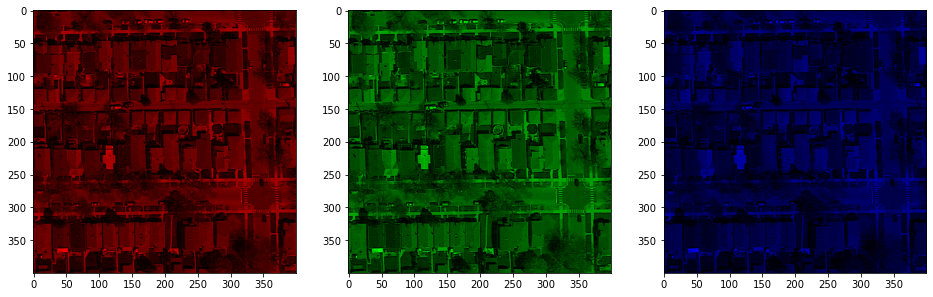

In [3]:
plot_channels_img(imgs[9])

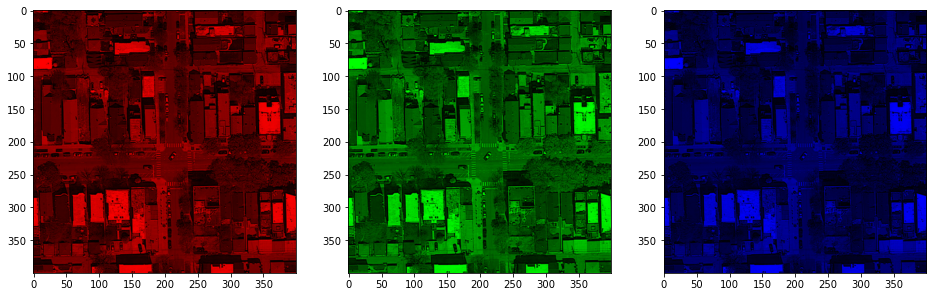

In [4]:
plot_channels_img(imgs[33])

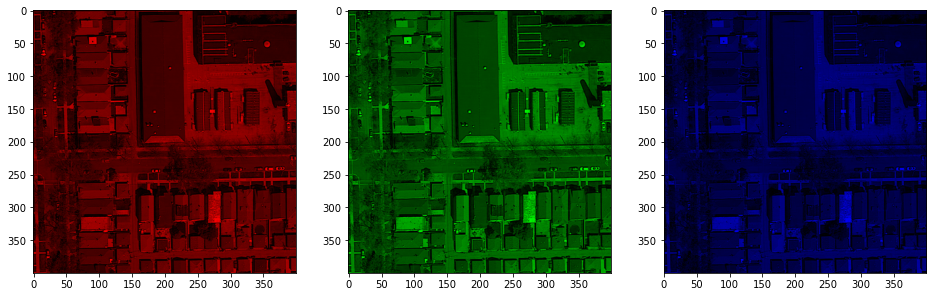

In [5]:
plot_channels_img(imgs[66])

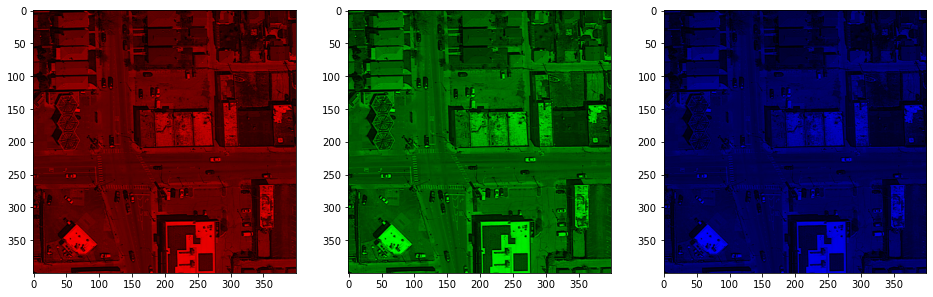

In [6]:
plot_channels_img(imgs[99])

We can observe that often the blue channel seems to have less contrast in it and therefore contains potentially less useful information. We also observe that often the lightest areas represent roofs of buildings. This will be used later for the post-processing of the predictions.

Let's also look at some image-ground truth pair (helper function provided).

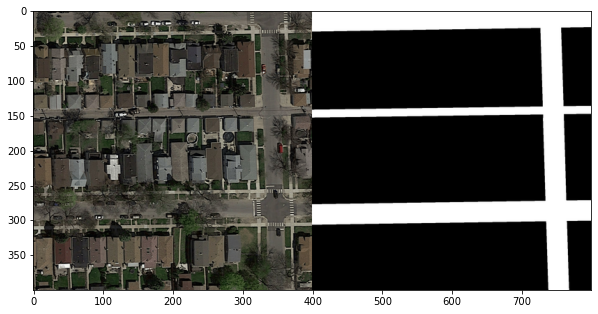

In [8]:
display_imgs_side_by_side(imgs[9], gt_imgs[9])
plt.show()

From this, we see that the mask very often form straight lines in the image. To improve predictions, we can try to encourage such shapes via doing some postprocessing on the predictions of our baseline ML model.

# Feature extraction

As proposed in the original notebook, we will decompose each image into independent patches and extract features for each of these patches, representing new data points on which we will train our baseline model.

The ground truth are constructed as follows : if more than 50% of the pixels in the patch are of class 1 (road), we let the patch be entirely of class 1, otherwise entirely of class 0.

As a baseline, we decided to extract the following features for each of the 16x16 patches :
- Mean of each channel
- Variance of channel
- Max of each channel

This yields a 9 features for each patches.

We further standardize these features.

In [3]:
# Decompose all the images into patches
patches, gt_patches = get_imgs_gt_patches(imgs, gt_imgs)

# Extract the features and the corresponding ground truth labels
X = extract_features_from_patches(patches, extract_baseline_features)
y = build_gt_from_patches(gt_patches,
                          lambda gt_patch: value_to_class(gt_patch, threshold=0.5))

In [5]:
print(patches.shape)

(62500, 16, 16, 3)


In [10]:
X.shape

(62500, 9)

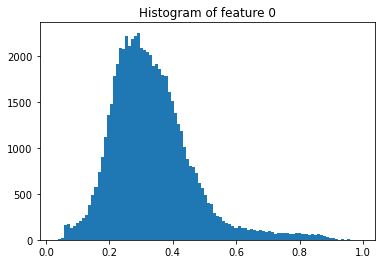

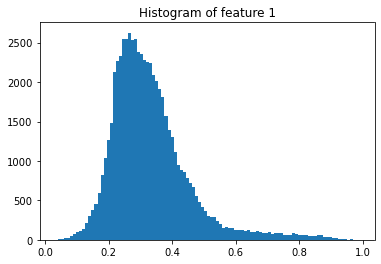

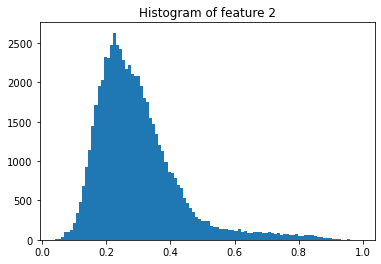

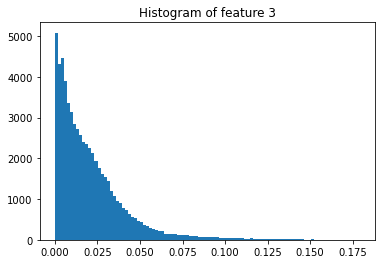

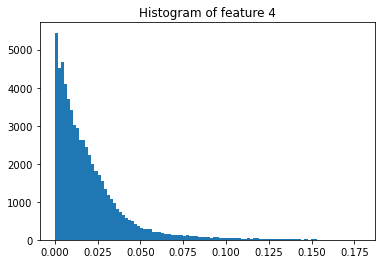

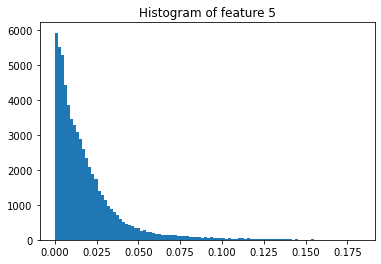

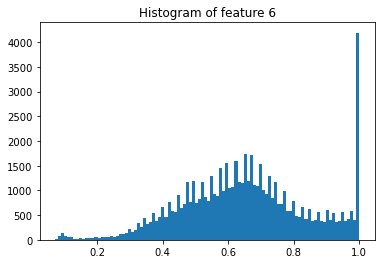

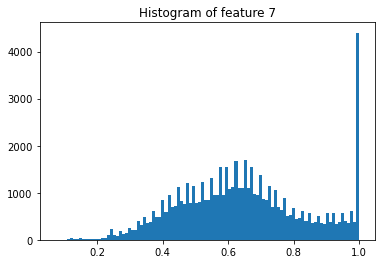

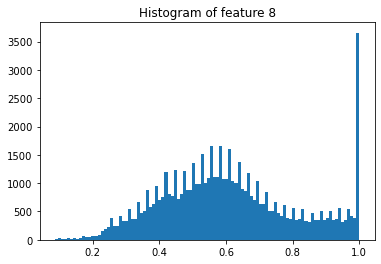

In [11]:
plot_features_distributions(X)

From the above distribution, we see that the first 0-2 and 6-8 features (the means and max of each channel) are relatively well distributed but the features 3-5 are very concentrated toward 0. To mitigate this issue, we decided to apply a log transformation these features.

In [12]:
X_transformed = X.copy()

# Apply log transformations to features 3-5
X_transformed[:, 3:6] = np.log(X_transformed[:, 3:6])

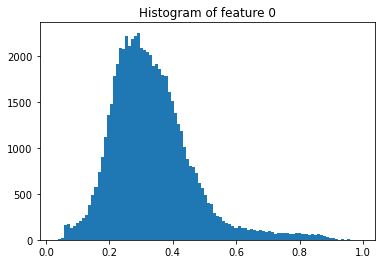

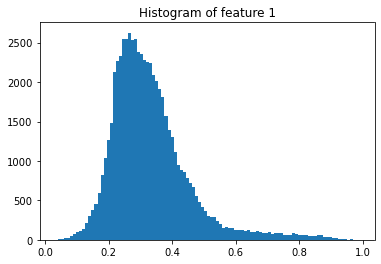

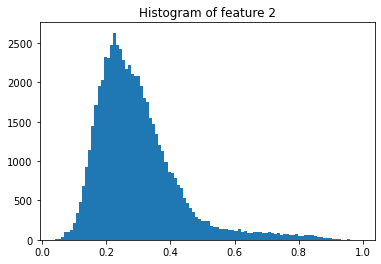

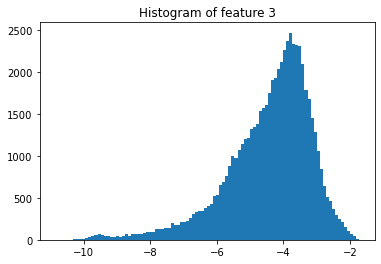

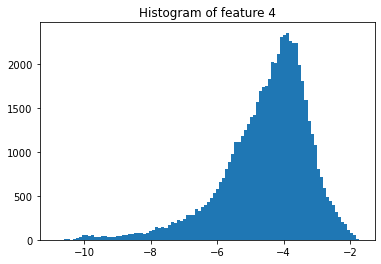

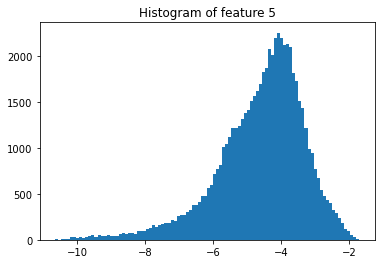

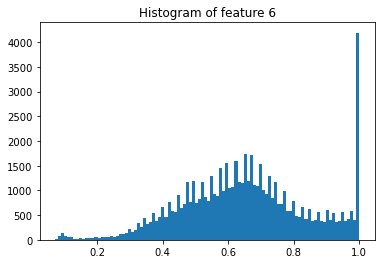

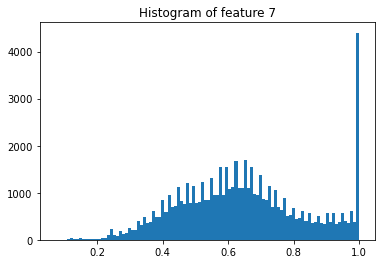

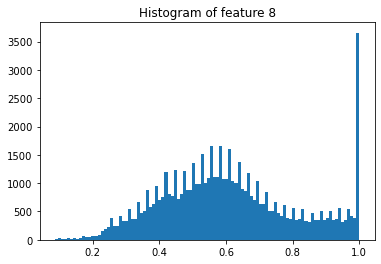

In [13]:
plot_features_distributions(X_transformed)

Now the distributions looks better. We will also standardize them since they don't have the same scales. But first we split our data into a training and a test set.

In [14]:
X_train, y_train, X_test, y_test = split_data(X_transformed, y, ratio=0.8)

In [15]:
# Standardize the features
X_train, means, stds = standardize_features(X_train)

# Standardize the test data with the same statistics
X_test, _, _ = standardize_features(X_test, means=means, stds=stds)

In [16]:
X_train.shape

(50000, 9)

In [17]:
X_test.shape

(12500, 9)

In [18]:
# Percentage of class 1 in the training set
np.mean(y_train)

0.19286

We see that our training dataset only contains around 20% of class 1 (road) samples. We will need to weight the model. Otherwise they will tend to only learn to detect negative (class 0) samples and will have a very poor recall.

# Baseline models
We will try the following models for our baseline models :
- Logistic regression
- SVM (no kernel)
- SVM (RBF kernel)
- Gradient Boosting classifier : perform ensemble learning via boosting using decision tree as the base classifier

## Logistic regression

In [19]:
from sklearn.linear_model import LogisticRegression

# Specify class_weight to mitigate issue cited above
log_reg = LogisticRegression(class_weight='balanced')

# Fit the data
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [20]:
_, _, _, _ = compute_scores(y_test, log_reg.predict(X_test))

Performance on the local test set
	F1-score : 0.3864
	Recall : 0.5853
	Precision : 0.2883
	Accuracy : 0.6460


We can observe that the precision is rather low, i.e. we tend to over classify as positive (high false positive rate).

## SVM

### SVM without kernel (linear classifier)

In [21]:
from sklearn.svm import SVC

# Linear kernel, by default uses a L2 regularizer
svm_lin = SVC(class_weight='balanced', kernel='linear', cache_size=7000)

svm_lin.fit(X_train, y_train)

SVC(cache_size=7000, class_weight='balanced', kernel='linear')

In [22]:
_, _, _, _ = compute_scores(y_test, svm_lin.predict(X_test))

Performance on the local test set
	F1-score : 0.3889
	Recall : 0.5832
	Precision : 0.2917
	Accuracy : 0.6510


The performances are similar to the logistic regression above.

### SVM with RBF kernel

In [23]:
# Radial Basis Function kernel, by default uses a L2 regularizer
svm_rbf = SVC(class_weight='balanced', kernel='rbf', cache_size=7000)

In [24]:
svm_rbf.fit(X_train, y_train)

SVC(cache_size=7000, class_weight='balanced')

In [25]:
_, _, _, _ = compute_scores(y_test, svm_rbf.predict(X_test))

Performance on the local test set
	F1-score : 0.5057
	Recall : 0.7958
	Precision : 0.3706
	Accuracy : 0.7038


Using a RBF kernel helps a lot the model but we are still a bit low on the precision.


Let's try to find a good coefficient for the regularizer via cross validation. We take the score to be the f1 score.

In [26]:
from sklearn.model_selection import cross_validate

# Different coefficients for the L2 regularizer
Cs = [1, 500, 1e3, 1e4]
f1_scores = []

for C in Cs:
    svm_rbf = SVC(C=C, class_weight='balanced', kernel='rbf', cache_size=1000)
    cv_results = cross_validate(svm_rbf, X_train, y_train, scoring='f1', n_jobs=-1)
    
    # Compute mean test f1 score over each fold
    f1_scores.append(np.mean(cv_results['test_score']))
    
    print(f'F1-score for C={C} : {f1_scores[-1]}')

F1-score for C=1 : 0.508059309274609
F1-score for C=500 : 0.5687745627920442
F1-score for C=1000.0 : 0.572030679319991
F1-score for C=10000.0 : 0.5805703358638834


F1-score for C=1 : 0.5062791659175732
F1-score for C=500 : 0.5673612762271919
F1-score for C=1000.0 : 0.5713562114765212
F1-score for C=10000.0 : 0.5811883579833611

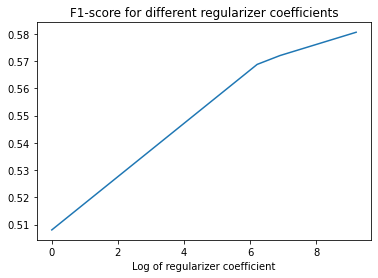

In [27]:
plt.plot(np.log(Cs), f1_scores)
plt.title('F1-score for different regularizer coefficients')
plt.xlabel('Log of regularizer coefficient')
plt.show()

In [ ]:
C_best = Cs[np.argmax(f1_scores)]
print(f'Best C : {C_best}')

# Enable probability estimates
svm_rbf = SVC(C=C_best, class_weight='balanced',
              kernel='rbf', cache_size=7000,
              probability=True)

svm_rbf.fit(X_train, y_train)

Best C : 10000.0


In [ ]:
y_pred_svm_rbf = svm_rbf.predict(X_test)
_, _, _, _ = compute_scores(y_test, y_pred_svm_rbf)

In [ ]:
# Save fitted models as it takes long to train
from joblib import dump, load

dump(svm_rbf, weights_folder+ 'svm_rbf/svm_rbf_fitted_model.joblib') 

## GradientBoosting Classifier
This algorithm tries to iteratively improve the preceeding weak learner and do ensemble learning.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Use many weak learners as Gradient boosting is
# rather robust to overfitting
# Use trees with a depth of at most 5
gbc = GradientBoostingClassifier(n_estimators=1000, max_depth=5)

gbc.fit(X_train, y_train)

In [ ]:
y_pred_gbc = gbc.predict(X_test)
_, _, _, _ = compute_scores(y_test, y_pred_gbc)

Interestingly, we can observe that with Gradient Boosting we have a better precision but a worse recall than before. This means we tend to be more sure when we detect a road (high precision) but we often miss road samples.


This can be interesting to try to combine the Gradient Boosting Classifier and the kernel SVM as they seem to be complementary regarding the recall and precision.

## Combining GradientBoosting and kernel SVM

We will combine (ensemble learning) the predictions probabilities (to take into account the confidence of the model) of both models and train a logistic regression on them to output a final prediction.

In [ ]:
# Combine the predictions proba of both fitted models
# into new features
y_pred_svm_rbf = svm_rbf.predict_proba(X_train)
y_pred_gbc = gbc.predict_proba(X_train)

# Only keep proba for class 1
y_pred_svm_rbf = y_pred_svm_rbf[:, 1]
y_pred_gbc = y_pred_gbc[:, 1]

X_ens_train = np.concatenate((y_pred_svm_rbf.reshape(-1, 1), y_pred_gbc.reshape(-1, 1)), axis=1)

# Also compute the predictions of both models on the test set
y_pred_svm_rbf = svm_rbf.predict_proba(X_test)
y_pred_gbc = gbc.predict_proba(X_test)

y_pred_svm_rbf = y_pred_svm_rbf[:, 1]
y_pred_gbc = y_pred_gbc[:, 1]

X_ens_test = np.concatenate((y_pred_svm_rbf.reshape(-1, 1), y_pred_gbc.reshape(-1, 1)), axis=1)

In [ ]:
X_ens_train.shape

In [ ]:
log_reg_ens = LogisticRegression(class_weight='balanced')
log_reg_ens.fit(X_ens_train, y_train)

In [ ]:
_, _, _, _ = compute_scores(y_test, log_reg_ens.predict(X_ens_test))

We improved the accuracy. The recall and precision are both more or less similar but are below the "specialized" models above. This makes the F1-score slightly worse than e.g. the kernel svm.